In [2]:
# Keras Nerual Network Model Notebook

In [3]:
# ---------------------------------- #

In [6]:
# import functions from model_functions notebook

In [325]:
top_features = [
     'LotArea',
     'LotFrontage',
     'BsmtUnfSF',
     'GrLivArea',
     'OverallQual',
     'HouseSFScore',
     'BsmtFinSF1',
     'GarageArea',
     'PorchScore',
     'BsmtIncompleteRatio',
     '2ndFlrSF',
     'GarageYrBlt',
     'MasVnrArea',
     'overallScore',
     'WoodDeckSF',
     '1stFlrSF',
     'YearBuilt',
     'OverallCond',
     'ageScore',
     'TotalBsmtSF',
     'YearRemodAdd',
     'BathScore',
     'Neighborhood_StoneBr',
     'OpenPorchSF',
     'YrSold',
     'BsmtFinSF2',
     'Neighborhood_Crawfor',
     'ScreenPorch',
     'Functional_NonTyp',
     'Neighborhood_Somerst'
]

In [262]:
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras import regularizers

In [351]:
%run -i model_functions.ipynb

In [352]:
# Function to call all feature engineering functions
def feature_engineering(df):
    print("Starting feature engineering...")
    df = year_to_age(df)
    df = build_meta_features(df)
    df = log_xform_features(df)
    print("Feature engineering complete.")
    return df

In [154]:
def log_xform(df):
    df = log_xform_features(df)
    return df

In [340]:
def run_model():
    
    train_data, test_data = get_data()
    
    # experiment: adding xgboost data to the training and testing data
    xgb_train, xgb_test = get_data(train_data_path='xgb_influence_train.csv', test_data_path='xgb_influence_test.csv')
    train_data, test_data = train_data.join(xgb_train), test_data.join(xgb_test)
    
    target = train_data['SalePrice']
    train_data = remove_null_columns(train_data)
    numerical_features, categorical_features = get_feature_lists(train_data)
    
    df_num_train, df_cat_train = impute_features(train_data[numerical_features].copy(), train_data[categorical_features].copy())
    df_num_test, df_cat_test = impute_features(test_data[numerical_features].copy(), test_data[categorical_features].copy())
    
    df_num_train, df_num_test = feature_engineering(df_num_train.copy()), feature_engineering(df_num_test.copy())
    df_num_train, df_num_test = scale_features(df_num_train.copy()), scale_features(df_num_test.copy())
    
    common_categories = prune_categorical_features(df_cat_train, df_cat_test)
    
    df_train = combine_dataframes(df_num_train, df_cat_train[common_categories])
    df_test = combine_dataframes(df_num_test, df_cat_test[common_categories])
    
#     df_train = feature_engineering(df_train.copy())
#     df_test = feature_engineering(df_test.copy())
    
    # Change the line below to substitute different models
    model = keras_model(df_train, target=target)
    
    predictions = model.predict(df_test)
    
    create_submission(test_data, predictions)
    
    return model, df_train

In [264]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [216]:
def scale_features(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

In [326]:
train_data, test_data = get_data()
target = train_data['SalePrice']
train_data = remove_null_columns(train_data)
numerical_features, categorical_features = get_feature_lists(train_data)

df_num_train, df_cat_train = impute_features(train_data[numerical_features].copy(), train_data[categorical_features].copy())
df_num_test, df_cat_test = impute_features(test_data[numerical_features].copy(), test_data[categorical_features].copy())

df_num_train, df_num_test = feature_engineering(df_num_train.copy()), feature_engineering(df_num_test.copy())
df_num_train, df_num_test = scale_features(df_num_train.copy()), scale_features(df_num_test.copy())

common_categories = prune_categorical_features(df_cat_train, df_cat_test)

df_train = combine_dataframes(df_num_train, df_cat_train[common_categories])
df_test = combine_dataframes(df_num_test, df_cat_test[common_categories])

df_train, df_test = df_train.copy()[top_features], df_test.copy()[top_features]

Grabbing train data from 'data/train.csv'...
Grabbing test data from 'data/test.csv'...
Data successfully loaded.
Removing columns that are >50% null...
4 columns were removed.
Obtaining feature column names...
34 numeric features obtained; 41 categorical features obtained
Imputing data...
Imputation complete.
There are now 34 numerical features and 177 categorical features.
Imputing data...
Imputation complete.
There are now 34 numerical features and 172 categorical features.
Starting feature engineering...
Feature engineering: transforming years to time since...
Feature engineering: log transform of relevant numerical features...
Feature engineering complete.
Starting feature engineering...
Feature engineering: transforming years to time since...
Feature engineering: log transform of relevant numerical features...
Feature engineering complete.


In [163]:
df_test.head()

,LotArea,LotFrontage,BsmtUnfSF,GrLivArea,OverallQual,HouseSFScore,BsmtFinSF1,GarageArea,PorchScore,BsmtIncompleteRatio,2ndFlrSF,GarageYrBlt,MasVnrArea,overallScore,WoodDeckSF,1stFlrSF,YearBuilt,OverallCond,ageScore,TotalBsmtSF,YearRemodAdd,BathScore,Neighborhood_StoneBr,OpenPorchSF,YrSold
0,0.566300,0.589174,0.730486,0.312002,0.444444,0.030477,0.741323,0.902620,0.000013,0.000206,0.000000,0.788462,0.000000,0.400000,0.681466,0.312002,0.374046,0.625,0.383735,0.794653,0.816667,0.000000,0,0.000000,0.0
1,0.622472,0.594720,0.783517,0.467997,0.555556,0.068093,0.823054,0.786520,0.000004,0.000205,0.000000,0.798077,0.654926,0.485714,0.822970,0.467997,0.396947,0.625,0.426024,0.842638,0.866667,0.047619,0,0.546224,0.0
2,0.613950,0.554385,0.642487,0.548554,0.444444,0.058288,0.804475,0.845899,0.000004,0.000081,0.870383,0.673077,0.000000,0.328571,0.738274,0.325885,0.099237,0.500,0.042892,0.800602,0.200000,0.126984,0,0.537818,0.0
3,0.524520,0.577872,0.754180,0.542433,0.555556,0.057270,0.771613,0.842455,0.000004,0.000251,0.865959,0.669872,0.425024,0.485714,0.810925,0.325032,0.091603,0.625,0.040482,0.800350,0.200000,0.126984,0,0.546224,0.0
4,0.335525,0.313321,0.903060,0.453130,0.777778,0.063167,0.672061,0.852536,0.001260,0.001800,0.000000,0.689103,0.000000,0.542857,0.000000,0.453130,0.137405,0.500,0.073735,0.838240,0.300000,0.047619,1,0.668438,0.0


In [341]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.2, random_state=23)

In [238]:
# def basic_model_1(x_size, y_size):
#     t_model = Sequential()
#     t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
#     t_model.add(Dense(50, activation="relu"))
#     t_model.add(Dense(y_size))
#     print(t_model.summary())
#     t_model.compile(loss='mean_squared_error',
#         optimizer=Adam(),
#         metrics=[metrics.mae])
#     return(t_model)

In [342]:
X_train.shape

(1168, 30)

In [240]:
model = Sequential()

In [241]:
model.add(Dense(100, activation='tanh', input_shape=(X_train.shape[1],)))

In [242]:
model.add(Dense(50, activation='relu'))

In [244]:
model.add(Dense(1))

In [245]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 100)               2600      
_________________________________________________________________
dense_196 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None


In [247]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [251]:
def baseline_model():
#     adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = Sequential()
    model.add(Dense(100, activation='tanh', input_shape=(X_train.shape[1],)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [343]:
def basic_model_3():
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(X_train.shape[1],)))
    t_model.add(Dropout(0.3))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
                      kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
                      kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(1))
    t_model.compile(loss='mean_squared_error', optimizer='adam')
    return(t_model)

In [296]:
model

In [344]:
estimator = KerasRegressor(build_fn=basic_model_3, nb_epoch=200, batch_size=5, verbose=0)

In [345]:
kfold = KFold(n_splits=10, random_state=42)

In [280]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold, n_jobs=1)

In [281]:
print("Results: {} ({}) MSE".format(results.mean(), results.std()))

Results: -7878878956.754259 (2460623974.4745364) MSE


In [346]:
estimator.fit(X_train, y_train, epochs=4000, batch_size=128, verbose=0)

In [306]:
score = estimator.evaluate(X_test, y_test, batch_size=128)

AttributeError: 'KerasRegressor' object has no attribute 'evaluate'

In [299]:
score

491640789.91780823

In [185]:
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res / (SS_tot + K.epsilon()) )

In [336]:
predictions = estimator.predict(df_test)
    
create_submission(test_data, predictions)

Generating submission file...
Submission file is ready.


In [337]:
r2_score

<function sklearn.metrics.regression.r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')>

In [347]:
r2_score(y_pred=estimator.predict(df_train), y_true=train_data['SalePrice'])

0.89585227062660866

In [339]:
predictions

array([ 139012.046875,  188816.203125,  195299.1875  , ...,  194462.9375  ,
        136573.234375,  232848.03125 ], dtype=float32)

In [ ]:
keras_predictions = pd.DataFrame(predictions, columns=['keras_predictions'], index=)

In [348]:
corr_matrix = df_train.corr()

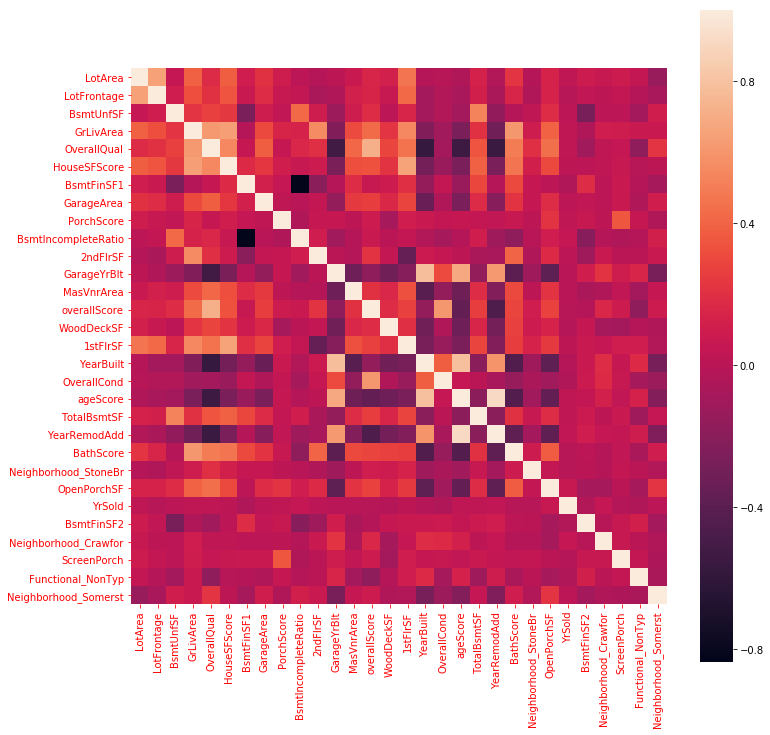

In [362]:
plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, square=True).tick_params(colors='red')

# plt.spines['bottom'].set_color('red')
# plt.spines['top'].set_color('red')
# plt.xaxis.label.set_color('red')
# plt.tick_params(axis='x', colors='red')

In [365]:
corr_matrix

,LotArea,LotFrontage,BsmtUnfSF,GrLivArea,OverallQual,HouseSFScore,BsmtFinSF1,GarageArea,PorchScore,BsmtIncompleteRatio,2ndFlrSF,GarageYrBlt,MasVnrArea,overallScore,WoodDeckSF,1stFlrSF,YearBuilt,OverallCond,ageScore,TotalBsmtSF,YearRemodAdd,BathScore,Neighborhood_StoneBr,OpenPorchSF,YrSold,BsmtFinSF2,Neighborhood_Crawfor,ScreenPorch,Functional_NonTyp,Neighborhood_Somerst
LotArea,1.000000,0.654004,0.047510,0.385457,0.178220,0.376486,0.096966,0.206555,0.093358,0.011787,-0.012775,0.019681,0.071824,0.148771,0.122915,0.467442,-0.021943,-0.006308,-0.036267,0.125525,-0.027672,0.222533,-0.014213,0.137754,0.027164,0.084312,0.063026,0.087518,0.039683,-0.137660
LotFrontage,0.654004,1.000000,0.101425,0.321177,0.204399,0.345399,0.069293,0.184769,0.061999,0.044972,-0.056982,-0.041170,0.118959,0.144272,0.060838,0.422452,-0.088381,-0.031393,-0.072347,0.117028,-0.058630,0.150950,-0.037516,0.133768,-0.004808,0.036575,0.023383,0.044893,-0.023460,-0.074262
BsmtUnfSF,0.047510,0.101425,1.000000,0.223258,0.268446,0.235360,-0.265488,0.091182,0.031126,0.420684,0.091389,-0.121203,0.094866,0.185571,0.014448,0.150662,-0.090576,-0.030805,-0.090117,0.524372,-0.167086,-0.021333,0.026063,0.182827,0.012495,-0.272666,0.013385,0.012820,-0.097074,0.105359
GrLivArea,0.385457,0.321177,0.223258,1.000000,0.614207,0.640776,-0.014440,0.298037,0.139366,0.138671,0.558571,-0.239671,0.307324,0.426731,0.218770,0.545990,-0.235500,-0.101960,-0.265656,0.206623,-0.311456,0.612100,0.091122,0.394999,0.030975,-0.042450,0.100849,0.090308,0.073164,0.068867
OverallQual,0.178220,0.204399,0.268446,0.614207,1.000000,0.545719,0.054199,0.376588,0.053474,0.157549,0.198064,-0.518018,0.417093,0.717167,0.283256,0.456066,-0.572323,-0.091932,-0.541432,0.344369,-0.550684,0.496350,0.196736,0.445101,0.027347,-0.101469,0.024109,0.049983,-0.174427,0.224010
HouseSFScore,0.376486,0.345399,0.235360,0.640776,0.545719,1.000000,0.168679,0.231673,0.107995,0.066467,0.081523,-0.259341,0.320342,0.338284,0.215854,0.656784,-0.290351,-0.127972,-0.267557,0.389260,-0.267569,0.467670,0.111551,0.300578,0.023551,0.014758,0.025358,0.062766,-0.009890,0.023817
BsmtFinSF1,0.096966,0.069293,-0.265488,-0.014440,0.054199,0.168679,1.000000,0.123409,0.046975,-0.837329,-0.205426,-0.026019,0.188221,0.060366,0.082144,0.198734,-0.151209,0.045200,-0.132981,0.290132,-0.012105,0.301784,0.054692,0.015075,-0.033702,0.185051,0.011162,0.073392,-0.024521,-0.081940
GarageArea,0.206555,0.184769,0.091182,0.298037,0.376588,0.231673,0.123409,1.000000,0.024759,0.001471,0.039580,-0.156969,0.241899,0.256163,0.161305,0.286678,-0.341207,-0.041019,-0.270327,0.177109,-0.207132,0.217223,0.055662,0.185063,0.016352,0.035878,0.013229,0.071056,-0.040706,0.104503
PorchScore,0.093358,0.061999,0.031126,0.139366,0.053474,0.107995,0.046975,0.024759,1.000000,-0.037954,0.052646,0.054255,0.019328,0.086058,-0.077113,0.096109,0.067815,0.040336,0.055273,0.041571,0.036260,0.066532,0.017987,0.213543,0.025861,0.062206,0.023755,0.353768,0.056728,-0.033754
BsmtIncompleteRatio,0.011787,0.044972,0.420684,0.138671,0.157549,0.066467,-0.837329,0.001471,-0.037954,1.000000,0.101272,-0.105253,-0.024609,0.073105,0.005765,0.043837,-0.030807,-0.080390,-0.018779,0.107909,-0.111642,-0.171351,-0.003967,0.101223,0.046650,-0.211440,-0.019042,-0.046854,-0.025854,0.117178
